# Modeling Reversal Task

### RW model of the reversal task in the aging experiment

The aim of this notbook is to see if age affects appetative reversal learning.

participants have 70 trials 40% reinforced.

reversal of stimuli occurs after 35 trials.

This notbook is based on Or's simulation of SCR.

## load libraries

In [1]:
%config Completer.use_jedi = False

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import theano
import theano.tensor as tt
import scipy
import pingouin as pg
import os

import pymc3 as pm
import arviz as az
import statsmodels.api as sm
import statsmodels.formula.api as smf

from glob import glob

/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Get data

make sure only participant with complete data set are loaded

In [8]:
#Load Age and MoCA scores from the session log file.
age = pd.read_excel('/media/Data/Lab_Projects/Aging/aging_session_log.xlsx', sheet_name='sessions').iloc[:,[0,7,9]]
moca = pd.read_excel('/media/Data/Lab_Projects/Aging/aging_session_log.xlsx', sheet_name='assessments').iloc[:,[0,22]]

# Change name of the first column to 'sub'
age.columns.values[0] = moca.columns.values[0] = "sub"

# remove unnecessary rows
age = age[age.gender != 'gender']
age = age.dropna().reset_index()
age = age.drop(['index'], axis=1)

print("Number of participants with age: ",age.shape[0],'; females: ', age[age['gender']=='F'].shape[0])
# merge files
age = age.merge(moca, left_on='sub', right_on='sub')
age['sub'] = age['sub'].map(lambda x: int(x.lstrip('AG_'))) # remove the AG_ prfix from the subject number
age['sub'] = age['sub'].astype(int)
age['age'] = age.age.astype('int')

print('Number of participants with MoCA: ', age.shape[0], '; MoCA > 25:', age[age.moca_score>25].shape[0],'; females: ', age[age['gender']=='F'].shape[0])
print('mean:', np.mean(age.age), 'std:', np.std(age.age), 'min-max:',np.min(age.age),np.max(age.age))
age_c = age[age['moca_score']>25]
print('mean:', np.mean(age_c.age), 'std:', np.std(age_c.age), 'min-max:',np.min(age_c.age),np.max(age_c.age))

Number of participants with age:  91 ; females:  43
Number of participants with MoCA:  81 ; MoCA > 25: 63 ; females:  38
mean: 54.45679012345679 std: 22.04151491663287 min-max: 18 89
mean: 51.888888888888886 std: 21.99863712308943 min-max: 18 88


In [9]:
glober = '/media/Data/Lab_Projects/Aging/behavioral/Reversal/AG_*_RV/ETLearning_*.csv'

db = pd.DataFrame()

for sub in glob(glober):
    
    try:
        df = pd.read_csv(sub)
        df['sub'] = sub.split('_')[2]
        if df.shape[0] == 70:
            db = pd.concat([db, df], axis = 0)
            #db = db.append(df)#[df.trialNum<36])
    except:
        print(sub)
        print('error')

#db['rating'] = db['rating'].replace(0, np.nan)
db = db.sort_values(by=['sub','trialNum'])
print('number of subject: ', len(db['sub'].unique()))

number of subject:  88


In [10]:
db['sub'] = db['sub'].astype('int')
db = db.merge(age_c, left_on='sub', right_on='sub')
#db = db[db.moca_score >25]
db = db.sort_values('sub')
print('Valid subjects: ', len(np.unique(db['sub'])))

Valid subjects:  63


In [11]:
x = db[db['RT']==-1].groupby('sub').count()['rating']
x = x[x>5].reset_index()
print(x)
db = db[~db['sub'].isin(x['sub'].values)]

   sub  rating
0  102      13


In [12]:
subs = db.drop_duplicates('sub')
subs = subs.drop(['trialNum', 'rectOri', 'rectValue', 'rating', 'RT'],axis = 1).reset_index()
subs.head()

,index,sub,gender,age,moca_score
0,0,10,M,18,28
1,470,11,F,43,26
2,508,13,F,48,28
3,609,14,F,26,30
4,663,15,F,58,26


## get descriptive data

In [13]:
n_subj   = len(db['sub'].unique())
n_trials = max(db.trialNum)

trials, subj = np.meshgrid(range(n_trials), range(n_subj))
trials = tt.as_tensor_variable(trials.T)
subj   = tt.as_tensor_variable(subj.T)

In [14]:
stim   = np.reshape([db['rectOri']],   (n_subj, n_trials)).T
reward = np.reshape([db['rectValue']], (n_subj, n_trials)).T
rating = np.reshape([db['rating']],    (n_subj, n_trials)).T

stim   = np.array(stim/45,  dtype='int')
reward = np.array(reward/6*9, dtype='int')

In [15]:
stim = tt.as_tensor_variable(stim)
reward = tt.as_tensor_variable(reward)

In [16]:
rating = [np.nan if 0 else x for x in rating]

# create a pymc3 model

In [17]:
 
# generate functions to run
def update_Q(stim, reward,
             Qs,vec,
             alpha, n_subj):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by theano.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the theano.scan fn argument:
        fn=lamba action, reward, Qs, alpha: tt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """
     
    PE = reward - Qs[tt.arange(n_subj), stim]
    Qs = tt.set_subtensor(Qs[tt.arange(n_subj),stim], Qs[tt.arange(n_subj),stim] + alpha * PE)
    
    # in order to get a vector of expected outcome (dependent on the stimulus presentes [CS+, CS-] 
    # we us if statement (switch in theano)
    vec = tt.set_subtensor(vec[tt.arange(n_subj),0], (tt.switch(tt.eq(stim,1), 
                                                                Qs[tt.arange(n_subj),1], Qs[tt.arange(n_subj),0])))
    
    return Qs, vec

In [22]:
# generate functions to run
def update_Q_hall(stim, reward,
             Qs,vec,alpha,assoc,
             eta,kappa, n_subj):
    """
    This function updates the Q table according to Hybrid PH model
    For information, please see this paper: https://www.sciencedirect.com/science/article/pii/S0896627316305840?via%3Dihub
  
    """
      
    delta = reward - Qs[tt.arange(n_subj), stim]
    alpha = tt.set_subtensor(alpha[tt.arange(n_subj), stim], eta * abs(delta) + (1-eta)*alpha[tt.arange(n_subj), stim])
    Qs = tt.set_subtensor(Qs[tt.arange(n_subj),stim], Qs[tt.arange(n_subj),stim] + kappa*alpha[tt.arange(n_subj), stim] * delta)
    
    # in order to get a vector of expected outcome (dependent on the stimulus presentes [CS+, CS-] 
    # we us if statement (switch in theano)
    vec = tt.set_subtensor(vec[tt.arange(n_subj),0], (tt.switch(tt.eq(stim,1), 
                                                                Qs[tt.arange(n_subj),1], Qs[tt.arange(n_subj),0])))
    
    # we use the same idea to get the associability per trial
    assoc = tt.set_subtensor(assoc[tt.arange(n_subj),0], (tt.switch(tt.eq(stim,1), 
                                                                alpha[tt.arange(n_subj),1], alpha[tt.arange(n_subj),0])))
    
    return Qs, vec, alpha, assoc


In [18]:
# try alpha as beta distribution
with pm.Model() as mB:
    
   # betaHyper= pm.Normal('betaH', 0, 1)
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, 5, shape=n_subj)
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 4.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 4.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, reward],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = vec[trials,subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=rating) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    trB = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 894 seconds.


In [19]:
# try with intercept
with pm.Model() as mB_I:
    
   # betaHyper= pm.Normal('betaH', 0, 1)
    intercept = pm.Normal('intercept', 0, 5)
    
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, 5, shape=n_subj)
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 4.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 4.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, reward],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = vec[trials,subj,0] * beta[subj] + intercept
    
    scrs = pm.Normal('scrs', vec_, eps, observed=rating) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    trB_I = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, beta, alpha, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 707 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [20]:
# try with random intercept
with pm.Model() as mB_Is:
    
   # betaHyper= pm.Normal('betaH', 0, 1)
    intercept = pm.Normal('intercept', 0, 5, shape=n_subj)
    
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, 5, shape=n_subj)
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 4.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 4.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, reward],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = vec[trials,subj,0] * beta[subj] + intercept[subj]
    
    rates = pm.Normal('rates', vec_, eps, observed=rating) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    trB_Is = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, beta, alpha, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4406 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


## hierarchal model

In [21]:
# try alpha as beta distribution
with pm.Model() as m_H:
    
    # intercept
    mu = pm.Normal('mu', 0, 1)
    sd = pm.HalfNormal('sd',5) 
    intercept_matt = pm.Normal('intercept_matt', mu=0, sd=1, shape=n_subj)
    intercept = pm.Deterministic('intercept',intercept_matt + mu*sd)
    
    phi = pm.Uniform("phi", lower=0.0, upper=1.0)

    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", tt.exp(kappa_log))

    alpha = pm.Beta("alpha", alpha=phi * kappa, beta=(1.0 - phi) * kappa, shape=n_subj)
    
    
    beta_h = pm.Normal('beta_h', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', 1)
    beta = pm.Normal('beta',beta_h, beta_sd, shape=n_subj)
       
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 4.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec0 = 4.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, reward],
        outputs_info=[Qs, vec0],
        non_sequences=[alpha, n_subj])
   
     
    vec_ = vec[trials, subj,0] * beta[subj] + intercept[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=rating) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    tr_hB = pm.sample(target_accept=.9, chains=4, cores=8, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [eps, beta, beta_sd, beta_h, alpha, kappa_log, phi, intercept_matt, sd, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8318 seconds.
There were 159 divergences after tuning. Increase `target_accept` or reparameterize.
There were 147 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 159 divergences after tuning. Increase `target_accept` or reparameterize.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


# The Pearce-Hall Hybrid model

This is an attempt to build the PH Hybrid model.</br>
This model doesn't assume a simple constant learning rate (as the RW), rather, it incorporated both a constant learning rate and a dynamic one. </br>
The dynamic one is being updated by the amount of new information given.</br> 
The model goes like that: </br>
(1) Vi(k+1) = Vi (k) + κα(k)δ </br>
(2) δ = reward - Vi(k) </br>
(3) α(k+1) = η|δ|+(1-η)α(k)</br>

So the current value is an update of the previous one plus a constant learning rate (kappa) and an associability weight (α) (times the δ = prediction error). </br> 
The α is set by a constant weight of associability (η) and the previous α.


So now, our updating function will include those elements as well.

In [30]:
with pm.Model() as m:
  
    # hyperpriors for eta and kappa
    phi = pm.Uniform("phi", lower=0.0, upper=1.0, shape=2)
    
    # κ   
    k_log1 = pm.Exponential("k_log1", lam=1.5)
    k1 = pm.Deterministic("k1", tt.exp(k_log1))
    kappa = pm.Beta("kappa", alpha=phi[0] * k1, beta=(1.0 - phi[0]) * k1, shape=n_subj)
    
    # β
    beta_h = pm.Normal('beta_h', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', 5)
    beta = pm.Normal('beta',beta_h, beta_sd, shape=n_subj)
    
    # η
    k_log2 = pm.Exponential("k_log2", lam=1.5)
    k2 = pm.Deterministic("k2", tt.exp(k_log2))
    eta = pm.Beta('η', alpha=phi[1] * k2, beta=(1.0 - phi[1]) * k2, shape=n_subj)
    
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    alpha = 0 * tt.ones((n_subj,2), dtype='float64')
    assoc = 0 * tt.ones((n_subj,1), dtype='float64')
    
    [Qs,vec, alpha, assoc], updates = theano.scan(
        fn=update_Q_hall,
        sequences=[stim, reward],
        outputs_info=[Qs, vec, alpha, assoc],
        non_sequences=[eta, kappa, n_subj])
   
    
    vec_ = vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=rating) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    # add associabillity
    #assoc = pm.Deterministic('alpha', assoc)
    
    tr = pm.sample(target_accept=.9, chains=4, cores=4, return_inferencedata=True)

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'phi_interval__': array([0., 0.]), 'k_log1_log__': array(-1.0596601), 'kappa_logodds__': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'beta_h': array(0.), 'beta_sd_log__': array(1.38364656), 'beta': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'k_log2_log__': array(-0.77197803), 'η_logodds__': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'eps_log__': array(1.38364656)}

Initial evaluation results:
phi_interval__      -2.77
k_log1_log__        -1.06
kappa_logodds__    -99.52
beta_h              -0.92
beta_sd_log__       -0.77
beta              -142.76
k_log2_log__        -1.06
η_logodds__        -94.91
eps_log__           -0.77
scrs                  NaN
Name: Log-probability of test_point, dtype: float64

## model comparison

In [26]:
comp = az.compare({'basic model': trB, 'Model with intercept':trB_I, 'Model with random intercept':trB_Is, 'Hierarchical model': tr_hB}, ic='loo')
comp

/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/reve

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Hierarchical model,0,-10180.103487,86.812124,0.000000,0.531582,36.168318,0.000000,False,log
Model with random intercept,1,-10193.241947,151.630795,13.138460,0.319198,38.382245,8.533007,True,log
Model with intercept,2,-10215.680223,98.716597,35.576737,0.072153,35.964314,8.861496,True,log
basic model,3,-10225.106539,95.169704,45.003052,0.077068,37.752665,10.611417,True,log


<AxesSubplot:xlabel='Log'>

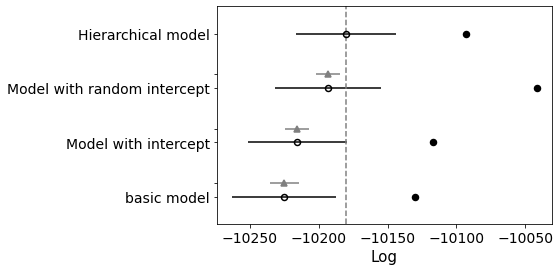

In [27]:
az.plot_compare(comp)

In [20]:
alpha = az.summary(tr_hB, var_names=['alpha'])[['mean']]
alpha['sub']=db['sub'].unique()
alpha = alpha.rename(columns={'mean': 'rw'})
#alpha = alpha.merge(subs, left_on='sub', right_on='sub')
alpha.to_csv('data/rw.csv')

Does adding age to the model improve prediction?

In [114]:
db['ageZ'] = (db['age'] - db['age'].mean())/db['age'].std(ddof=0)
db['age1'] = (db['age']/100)


In [20]:
ageZ = np.reshape([db['ageZ']], (n_subj, n_trials)).T
ageZ = np.array(ageZ/45,  dtype='float')
ageZ = tt.as_tensor_variable(ageZ)
ageZ

TensorConstant{[[-0.03750..03345798]]}

In [60]:
# try with random intercept
with pm.Model() as mB_Is_age:
    
   # betaHyper= pm.Normal('betaH', 0, 1)
    intercept = pm.Normal('intercept', 0, 5, shape=n_subj)
    
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, 5, shape=n_subj)
    eps = pm.HalfNormal('eps', 5)
    
    age = pm.Normal('age', 1, 1)
    
    Qs = 4.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 4.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, reward],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = vec[trials,subj,0] * beta[subj] + intercept[subj] + age*ageZ
    
    rates = pm.Normal('rates', vec_, eps, observed=rating) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    trB_Is_age = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [age, eps, beta, alpha, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1973 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [22]:
comp = az.compare({'basic model': trB, 'Model with intercept':trB_I, 'Model with random intercept':trB_Is, 'Hierarchical model': tr_hB}, ic='loo')
comp

/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/risk/lib/pyt

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Hierarchical model,0,-8414.603965,72.822960,0.000000,0.540571,31.951198,0.000000,False,log
Model with random intercept,1,-8426.166329,129.222544,11.562364,0.311692,33.946699,7.929614,True,log
Model with intercept,2,-8439.289395,82.137264,24.685430,0.147737,32.204852,8.676170,True,log
basic model,3,-8464.716495,82.332973,50.112530,0.000000,33.359304,9.679306,True,log


<AxesSubplot:xlabel='Log'>

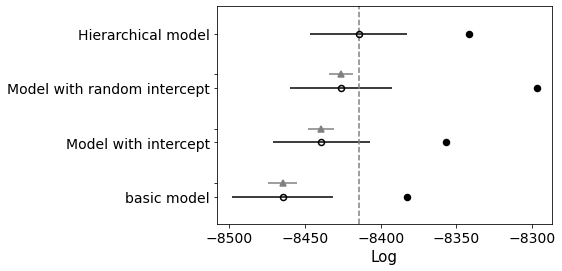

In [23]:
az.plot_compare(comp)

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'age'}>]], dtype=object)

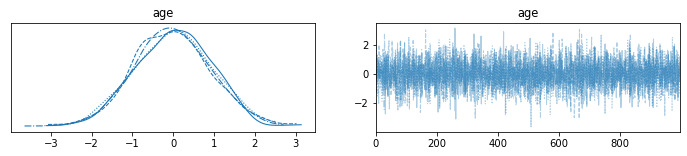

In [55]:
az.plot_trace(trB_Is_age, var_names='age')

In [57]:
az.summary(trB_Is_age, var_names='age')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
age,-0.012,0.946,-1.663,1.834,0.011,0.016,7225.0,3162.0,1.0


In [22]:
alpha = az.summary(tr_hB, var_names=['alpha'])[['mean']]
alpha['sub']=db['sub'].unique()
alpha = alpha.rename(columns={'mean': 'rw'})
alpha = alpha.merge(subs, left_on='sub', right_on='sub')
alpha.head()

,rw,sub,index,gender,age,moca_score
0,0.183,10,0,M,18,28.0
1,0.357,11,234,F,43,26.0
2,0.162,13,314,F,48,28.0
3,0.188,14,417,F,26,30.0
4,0.275,15,469,F,58,26.0


In [24]:
alpha.to_csv('data/rw.csv')

In [128]:
alpha = az.summary(tr_hB, var_names=['alpha'])[['mean']]
alpha['sub']=db['sub'].unique()
alpha = alpha.rename(columns={'mean': 'rw'})
alpha = alpha.merge(subs, left_on='sub', right_on='sub')
alpha['age'] = alpha['age'].astype('int')
alpha['ageZ'] = (alpha['age'] - alpha['age'].mean())/alpha['age'].std(ddof=0)
alpha['age2'] = (alpha['age']/100)

alpha['sex'] = alpha['gender'].map({'F':1, 'M':0})

pg.partial_corr(data=alpha, x='rw', y='age', covar='moca_score')

,n,r,CI95%,p-val
pearson,51,-0.171865,"[-0.43, 0.11]",0.232698


/tmp/ipykernel_254358/1499990709.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_robust = pm.sample(2000, cores=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam, x, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/pymc3/plots/posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(


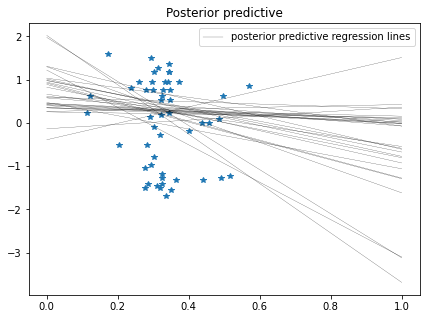

In [143]:
x = alpha['rw']
y = alpha['ageZ']


data = dict(x=x, y=y)
with pm.Model() as model_robust:
    family = pm.glm.families.StudentT()
    pm.glm.GLM.from_formula("y ~ x", data, family=family)
    trace_robust = pm.sample(2000, cores=2)

plt.figure(figsize=(7, 5))
plt.plot(x, y, "*")
pm.plot_posterior_predictive_glm(trace_robust, label="posterior predictive regression lines")
#plt.plot(x, true_regression_line, label="true regression line", lw=3.0, c="y")
plt.legend();

In [140]:
az.summary(trace_robust, hdi_prob=.89)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,70.790,12.257,49.647,88.945,0.346,0.247,1279.0,1355.0,1.0
x,-29.630,35.335,-81.948,30.923,1.003,0.762,1276.0,1350.0,1.0
lam,0.006,0.002,0.002,0.009,0.000,0.000,1471.0,1288.0,1.0


In [122]:
with pm.Model() as reg:
    
    intercept = pm.Normal('intercept', 0, 5)
    slope = pm.Normal('slope',0, 5)
    eps = pm.HalfNormal('eps', 5)
    tau = pm.Normal('tau', 0, 1)
    
    y_hat = slope*alpha.rw + intercept
    
    reg = pm.StudentT('reg', y_hat, eps, tau, observed=alpha['ageZ'].values) 
    
    trace_reg = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

az.summary(trace_reg, hdi_prob=.89)

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'intercept': array(0.), 'slope': array(0.), 'eps_log__': array(1.38364656), 'tau': array(0.)}

Initial evaluation results:
intercept   -2.53
slope       -2.53
eps_log__   -0.77
tau         -0.92
reg          -inf
Name: Log-probability of test_point, dtype: float64

Got error No model on context stack. trying to find log_likelihood in translation.
/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>],
       [<AxesSubplot:title={'center':'lam'}>,
        <AxesSubplot:title={'center':'lam'}>]], dtype=object)

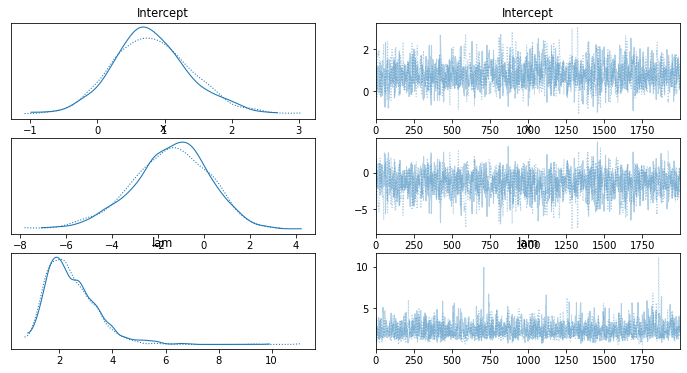

In [126]:
az.plot_trace(trace_robust)

array([<AxesSubplot:title={'center':'slope'}>,
       <AxesSubplot:title={'center':'intercept'}>], dtype=object)

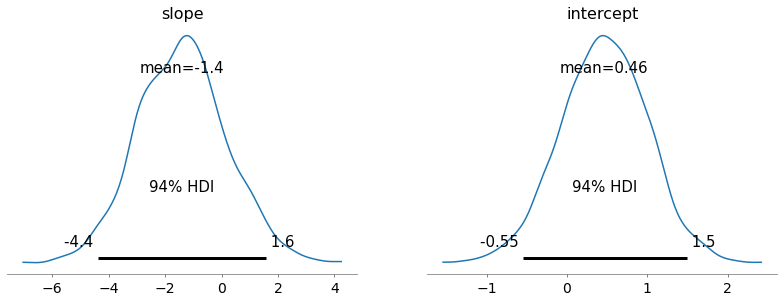

In [108]:
az.plot_posterior(trace_robust, var_names=['slope','intercept'])

In [109]:
az.summary(trace_reg, hdi_prob=.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.461,0.540,-0.417,1.262,0.014,0.010,1396.0,1513.0,1.0
slope,-1.390,1.572,-3.752,1.282,0.042,0.030,1390.0,1613.0,1.0
eps,1.040,0.111,0.872,1.217,0.003,0.002,1549.0,1608.0,1.0


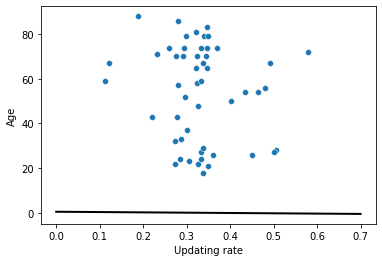

In [111]:
sns.scatterplot(x='rw', y='age', data = alpha)

plt.ylabel('Age')
plt.xlabel('Updating rate')

intercept = az.summary(trace_reg)['mean'][0]
slope = az.summary(trace_reg)['mean'][1]
x1 = 0
x2 = 0.7
y1 = intercept+slope*x1
y2 = intercept+slope*x2

plt.plot([x1, x2], [y1, y2], color='k', linestyle='-', linewidth=2)

In [97]:
alpha.to_csv('data/LR.csv')

In [59]:
pg.corr(alpha.rw,alpha.age)

,n,r,CI95%,p-val,BF10,power
pearson,51,-0.143775,"[-0.4, 0.14]",0.314154,0.286,0.17262


Text(0, 0.5, 'RW-learning rate')

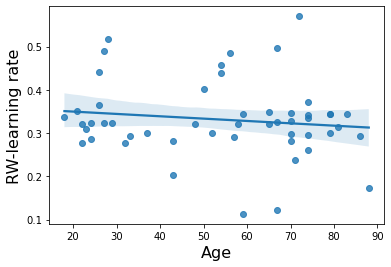

In [46]:
sns.regplot(x='age',y='rw', data=alpha)
plt.xlabel('Age', fontsize=16)
plt.ylabel('RW-learning rate', fontsize=16)

In [51]:
alpha = az.summary(trB_I, var_names=['alpha'])[['mean']]
alpha['sub']=db['sub'].unique()
alpha = alpha.merge(age, left_on='sub', right_on='sub')
alpha['age'] = alpha['age'].astype('int')
alpha.head(10)

,mean,sub,gender,age,moca_score
0,0.296,10,M,18,28
1,0.439,11,F,43,26
2,0.334,13,F,48,28
3,0.220,14,F,26,30
4,0.392,15,F,58,26
5,0.467,16,M,74,28
6,0.457,17,M,59,29
7,0.461,18,F,83,28
8,0.126,19,M,32,28
9,0.312,20,M,56,28


Text(0, 0.5, 'Alpha')

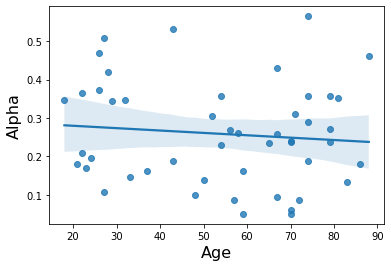

In [22]:
sns.regplot(x='age',y='mean', data=alpha)
plt.xlabel('Age', fontsize=16)
plt.ylabel('Alpha', fontsize=16)

In [23]:
pg.corr(alpha['age'], alpha['mean'])

,n,r,CI95%,p-val,BF10,power
pearson,48,-0.100563,"[-0.37, 0.19]",0.496454,0.225,0.104562


In [24]:
alpha.to_csv('data/alpha.csv')